### Languages of the countries of the world

Welcome to this notebook, where we will be analyzing the diversity of languages in the countries of the world. We will be working with a dataset accessed through wikipedia, originating from ethnologue (https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country). This dataset will be combined with a dataset containing more general country statistics accessed through Kaggle https://www.kaggle.com/datasets/fernandol/countries-of-the-world.

The data will be analyzed with the aim of elaboration on the following questions:


- In which countries are the most respectively least number of languages spoken?
- How well does the number of languages in a country correlate with its lingusitic diversity?
- How does the relationship between geography and linguistic diversity look?
- Is there any relationship between geographical factors and linguistic diversity?
- Is there a relationship between development and linguistic diversity?

Lets start by importing our four riders of the apocalypse:

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


Now we proceed with installing our datasets

In [96]:
Tables = pd.read_html('https://web.archive.org/web/20190428174546/https://www.ethnologue.com/statistics/country')

As there are multiple tables on the website, we will import them all and have to select the one that we are looking for:

In [97]:
len(Tables)

3

In [98]:
print(Tables[0], Tables[1], Tables[2])


      0     1     2
0   Feb   APR   Sep
1   NaN    28   NaN
2  2017  2019  2020                Country Living languages                                \
               Country            Count Percent Established Immigrant   
0          Afghanistan               42    0.59          41         1   
1        Aland Islands                3    0.04           3         0   
2              Albania               12    0.17           8         4   
3              Algeria               22    0.31          18         4   
4       American Samoa                7    0.10           2         5   
..                 ...              ...     ...         ...       ...   
237  Wallis and Futuna                3    0.04           3         0   
238     Western Sahara                4    0.06           3         1   
239              Yemen               17    0.24          11         6   
240             Zambia               55    0.77          46         9   
241           Zimbabwe               24    0

We see that the second table contains the values for countries, languages and diversty, so lets go ahead and save it away as our dataframe and have a first look.

In [99]:
lingo = Tables[1]

In [100]:
lingo.head()

Country Living languages                                \
          Country            Count Percent Established Immigrant   
0     Afghanistan               42    0.59          41         1   
1   Aland Islands                3    0.04           3         0   
2         Albania               12    0.17           8         4   
3         Algeria               22    0.31          18         4   
4  American Samoa                7    0.10           2         5   

  Number of speakers                 Diversity           
               Total     Mean Median     Index Coverage  
0           23352300   569568  16500     0.796      98%  
1              27652     9217   1450     0.100     100%  
2            2847936   284794   9820     0.518      83%  
3           38548160  1927408  40000     0.511      91%  
4              56090     9348  25890     0.215      86%

In [101]:
lingo.shape

(242, 10)

In [102]:
print(lingo.columns)

lingo.columns.values

MultiIndex([(           'Country',     'Country'),
            (  'Living languages',       'Count'),
            (  'Living languages',     'Percent'),
            (  'Living languages', 'Established'),
            (  'Living languages',   'Immigrant'),
            ('Number of speakers',       'Total'),
            ('Number of speakers',        'Mean'),
            ('Number of speakers',      'Median'),
            (         'Diversity',       'Index'),
            (         'Diversity',    'Coverage')],
           )


array([('Country', 'Country'), ('Living languages', 'Count'),
       ('Living languages', 'Percent'),
       ('Living languages', 'Established'),
       ('Living languages', 'Immigrant'), ('Number of speakers', 'Total'),
       ('Number of speakers', 'Mean'), ('Number of speakers', 'Median'),
       ('Diversity', 'Index'), ('Diversity', 'Coverage')], dtype=object)

So, all in all we have 242 rows and 10 columns. Now, looking at the columns, we see that the dataframe is MultiIndex, which means that each column contains a dataframe with columns. This is something we would rather avoid, and as such we turn it into a single index dataframe.

In [103]:
new_columns_names = ['country', 'lang_count', 'lang_count(%)', 'lang_count_established', 'lang_count_immigrant', 'nmb_of_speakers_total', 'nmb_of_speakers_mean', 'nmb_of_speakers_median', 'diversity_index', 'diversity_coverage']

lingo.columns = new_columns_names

Before moving on, lets give a brief overview of the columns in the dataset:

- Country: Name of the country being studied.

- lang_count: The number of languages found in a given country

- lang_count(%): Percentage of the worlds languages that are found in a given country

- lang_count_established/immigrant: These two columns signal how many of the languages in a given country are established, having been in the country for a long time, and immigrant, being recently introduced through immigration.

- nmb_of_speakers_total/mean/median: These three columns gives the total meand and median number of speakers of any language in a given country

- diveristy_index: Contains the diversity index of a given country, by its Greenberg's diversity index, which is the probability of two random speakers in a given country speak different languages as mother language.

- diversity_coverage: Gives the percentage of the population for which estimates of number of speakers are given. A higher values thus means that the diversity index is calculated based on more complete data


Lets now get a some more info on how the dataset actually looks.

In [104]:
lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         242 non-null    object 
 9   diversity_coverage      242 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 19.0+ KB


We see that there are no null values, but diversity index and coverege are non_numeric, which they should be. So lets first make them numeric

In [105]:
lingo['diversity_index'] = pd.to_numeric(lingo['diversity_index'], errors='coerce')
lingo.diversity_coverage = lingo.diversity_coverage.replace("%", "", regex=True)
lingo['diversity_coverage'] = pd.to_numeric(lingo['diversity_coverage'], errors='coerce')

lingo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 242 non-null    object 
 1   lang_count              242 non-null    int64  
 2   lang_count(%)           242 non-null    float64
 3   lang_count_established  242 non-null    int64  
 4   lang_count_immigrant    242 non-null    int64  
 5   nmb_of_speakers_total   242 non-null    int64  
 6   nmb_of_speakers_mean    242 non-null    int64  
 7   nmb_of_speakers_median  242 non-null    int64  
 8   diversity_index         239 non-null    float64
 9   diversity_coverage      242 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 19.0+ KB


We see that some missing values appeared in the diversity index when converting the data to numeric. We will go ahead and fill it in with the average value of the column

In [106]:
lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/1211858122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lingo['diversity_index'][lingo['diversity_index'].isnull()] = lingo['diversity_index'].mean()


Now what we will go ahead and do is to import our other datatable with the country statistic and merge it with our current language dataframe

In [107]:
Country_stats = pd.read_csv('countries of the world.csv')

In [108]:
Country_stats.head

<bound method NDFrame.head of              Country                               Region  Population  \
0       Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1           Albania   EASTERN EUROPE                          3581655   
2           Algeria   NORTHERN AFRICA                        32930091   
3    American Samoa   OCEANIA                                   57794   
4           Andorra   WESTERN EUROPE                            71201   
..               ...                                  ...         ...   
222       West Bank   NEAR EAST                               2460492   
223  Western Sahara   NORTHERN AFRICA                          273008   
224           Yemen   NEAR EAST                              21456188   
225          Zambia   SUB-SAHARAN AFRICA                     11502010   
226        Zimbabwe   SUB-SAHARAN AFRICA                     12236805   

     Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0            6

In [109]:
Country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

We see that there are some missing values for the dataframe, what we will do is to fill them in with the average of the column they are in and turn any stringrepresentations of numeric values into numerics.

In [110]:
Country_stats.replace(',', '.', regex=True, inplace=True)
for col in Country_stats.columns[2:]:
    Country_stats[col] = pd.to_numeric(Country_stats[col], errors='coerce')
    Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()


/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/2041408953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/2041408953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Country_stats[col][Country_stats[col].isnull()] = Country_stats[col].mean()
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/2041408953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [111]:
Country_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    float64
 5   Coastline (coast/area ratio)        227 non-null    float64
 6   Net migration                       227 non-null    float64
 7   Infant mortality (per 1000 births)  227 non-null    float64
 8   GDP ($ per capita)                  227 non-null    float64
 9   Literacy (%)                        227 non-null    float64
 10  Phones (per 1000)                   227 non-null    float64
 11  Arable (%)                          227 non-n

In [112]:
Country_stats

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.060000,163.070000,700.000000,36.000000,3.200000,12.13,0.22,87.65,1.0,46.600000,20.340000,0.380000,0.240000,0.380000
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.930000,21.520000,4500.000000,86.500000,71.200000,21.09,4.42,74.49,3.0,15.110000,5.220000,0.232000,0.188000,0.579000
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.390000,31.000000,6000.000000,70.000000,78.100000,3.22,0.25,96.53,1.0,17.140000,4.610000,0.101000,0.600000,0.298000
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.710000,9.270000,8000.000000,97.000000,259.500000,10.00,15.00,75.00,2.0,22.460000,3.270000,0.150844,0.282711,0.565283
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.600000,4.050000,19000.000000,100.000000,497.200000,2.22,0.00,97.78,3.0,8.710000,6.250000,0.150844,0.282711,0.565283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.9,0.00,2.980000,19.620000,800.000000,82.838278,145.200000,16.90,18.97,64.13,3.0,31.670000,3.920000,0.090000,0.280000,0.630000
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.0,0.42,0.038125,35.506964,9689.823009,82.838278,236.061435,0.02,0.00,99.98,1.0,22.114732,9.241345,0.150844,0.282711,0.400000
224,Yemen,NEAR EAST,21456188,527970,40.6,0.36,0.000000,61.500000,800.000000,50.200000,37.200000,2.78,0.24,96.98,1.0,42.890000,8.300000,0.135000,0.472000,0.393000
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.3,0.00,0.000000,88.290000,800.000000,80.600000,8.200000,7.08,0.03,92.90,2.0,41.000000,19.930000,0.220000,0.290000,0.489000


I won't go into depth explaining the columns in this dataframe, as they are fairly common knowledge and the columns pretty much speak for themselves. Population is the population of the country, GDP per capity is the GDP per capita of the country, etc.. The last three columns however might need some clarification. They contains how many percentage of the employed persons in the country are active in which economical sector: Agriculture, Industry or service. 


Now we can go ahead and merge the dataframes. The key value that we want to index on, the name of the country, has an ampty space as part of thes tring after the name in our Country_stats dataset. We therefore have to remove this so that the columns are indentical. Furthermore, our linguistic diversity dataset has more rows, signalling it has included more places than just countries, such as autonomous regions. We will therefore do an innerjoin, making sure that only the countries present in both dataset is part of the final dataset.

As some countrynames might not be spelled equally in the data set, we will change them

In [113]:
Country_stats.rename(columns={'Country':'country', 'Region':'region', 'Population':'population', 'Area (sq. mi.)':'area',
       'Pop. Density (per sq. mi.)':'pop_density', 'Coastline (coast/area ratio)':'Coast/area',
       'Net migration':'net_migration', 'Infant mortality (per 1000 births)':'infant_mortality',
       'GDP ($ per capita)':'GDP_per_capita', 'Literacy (%)':'literacy', 'Phones (per 1000)':'phones', 'Arable (%)':'arable',
       'Crops (%)':'crops', 'Other (%)':'other', 'Climate':'climate', 'Birthrate':'birthrate', 'Deathrate':'deathrate',
       'Agriculture':'agriculture', 'Industry':'industry', 'Service':'service' }, inplace=True)
i = 0
for x in Country_stats.country:
    Country_stats.loc[i,'country'] = Country_stats.loc[i,'country'][0:-1]
    i +=1

In [114]:
Country_stats.columns

Index(['country', 'region', 'population', 'area', 'pop_density', 'Coast/area',
       'net_migration', 'infant_mortality', 'GDP_per_capita', 'literacy',
       'phones', 'arable', 'crops', 'other', 'climate', 'birthrate',
       'deathrate', 'agriculture', 'industry', 'service'],
      dtype='object')

In [115]:
lingo[~lingo.country.isin(Country_stats['country'])].country.values

array(['Aland Islands', 'Antigua and Barbuda', 'Bahamas',
       'Bosnia and Herzegovina', 'British Indian Ocean Territory',
       'British Virgin Islands', 'Cape Verde Islands',
       'Caribbean Netherlands', 'Central African Republic',
       'China–Hong Kong', 'China–Macao', 'China–Taiwan',
       'Christmas Island', 'Cocos (Keeling) Islands', 'Congo', 'Curacao',
       'Czechia', 'Côte d’Ivoire', 'Democratic Republic of the Congo',
       'Eswatini', 'Falkland Islands', 'Gambia', 'Micronesia',
       'Montenegro', 'Myanmar', 'Niue', 'Norfolk Island', 'North Korea',
       'Northern Mariana Islands', 'Palestine', 'Pitcairn',
       'Russian Federation', 'Réunion', 'Saint Barthélemy',
       'Saint Kitts and Nevis', 'Saint Martin',
       'Saint Pierre and Miquelon', 'Sint Maarten', 'South Korea',
       'South Sudan', 'São Tomé e Príncipe', 'Tokelau',
       'Trinidad and Tobago', 'Turks and Caicos Islands',
       'U.S. Virgin Islands', 'Vatican State', 'Viet Nam'], dtype=object)

In [116]:
Country_stats[~Country_stats.country.isin(lingo['country'])].country.values

array(['Antigua & Barbuda', 'Bahamas. The', 'Bosnia & Herzegovina',
       'British Virgin Is.', 'Burma', 'Cape Verde',
       'Central African Rep.', 'Congo. Dem. Rep.', 'Congo. Repub. of the',
       "Cote d'Ivoire", 'Czech Republic', 'Gambia. The', 'Gaza Strip',
       'Hong Kong', 'Korea. North', 'Korea. South', 'Macau',
       'Micronesia. Fed. St.', 'Netherlands Antilles',
       'N. Mariana Islands', 'Reunion', 'Russia', 'Saint Kitts & Nevis',
       'St Pierre & Miquelon', 'Sao Tome & Principe', 'Swaziland',
       'Taiwan', 'Trinidad & Tobago', 'Turks & Caicos Is', 'Vietnam',
       'Virgin Islands', 'West Bank'], dtype=object)

In [117]:
lingo.replace('Russian Federation', 'Russia', inplace=True)
Country_stats.replace('Bosnia & Herzegovina', 'Bosnia and Herzegovina', inplace=True)
Country_stats.replace('Antigua & Barbuda', 'Antigua and Barbuda', inplace=True)
Country_stats.replace('British Virgin Is.', 'British Virgin Islands', inplace=True)
Country_stats.replace('Bahamas. The', 'Bahamas', inplace=True)
Country_stats.replace('Burma', 'Myanmar', inplace=True)
Country_stats.replace('Cape Verde', 'Cape Verde Islands', inplace=True)
Country_stats.replace('Central African Rep.', 'Central African Republic', inplace=True)
Country_stats.replace('Congo. Dem. Rep.', 'Democratic Republic of the Congo', inplace=True)
Country_stats.replace('Czech Republic', 'Czechia', inplace=True)
lingo.replace('China–Hong Kong', 'Hong Kong', inplace=True)
Country_stats.replace('Gambia. The', 'Gambia', inplace=True)
Country_stats.replace('Korea. North', 'North Korea', inplace=True)
Country_stats.replace('Korea. South', 'South Korea', inplace=True)
lingo.replace("`Cote d'Ivoire`", "`Côte d’Ivoire`", inplace=True)
Country_stats.replace('China–Macao', 'Macau', inplace=True)
Country_stats.replace('Micronesia. Fed. St.', 'Micronesia', inplace=True)
Country_stats.replace('Gaza Strip', 'Palestine', inplace=True)
Country_stats.replace('N. Mariana Islands', 'Northern Mariana Islands', inplace=True)
Country_stats.replace('Reunion', 'Réunion', inplace=True)
Country_stats.replace("Saint Kitts & Nevis", 'Saint Kitts and Nevis', inplace=True)
Country_stats.replace("Sao Tome & Principe", 'São Tomé e Príncipe', inplace=True)
Country_stats.replace("Swaziland", 'Eswatini', inplace=True)
Country_stats.replace("Congo. Repub. of the", 'Congo', inplace=True)
lingo.replace("China–Taiwan", 'Taiwan', inplace=True)
Country_stats.replace("Trinidad & Tobago", 'Trinidad and Tobago', inplace=True)
Country_stats.replace("Turks & Caicos Is", 'Turks and Caicos Islands', inplace=True)
Country_stats.replace("Vietnam", 'Viet Nam', inplace=True)
Country_stats.replace("Virgin Islands", 'U.S. Virgin Islands', inplace=True)

In [118]:
Country_stats.country.values

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Myanmar', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde Islands', 'Cayman Islands', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Democratic Republic of the Congo', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'East Timor', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faroe 

In [119]:
df = pd.merge(Country_stats, lingo, on='country', how = 'inner')

Okay, now we have our final data set. Lets do a quick inspection and then proceed with some plots :)

In [120]:
df.head(10)

,country,region,population,area,pop_density,Coast/area,net_migration,infant_mortality,GDP_per_capita,literacy,...,service,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.380000,42,0.59,41,1,23352300,569568,16500,0.796,98
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,0.579000,12,0.17,8,4,2847936,284794,9820,0.518,83
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.298000,22,0.31,18,4,38548160,1927408,40000,0.511,91
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,...,0.565283,7,0.10,2,5,56090,9348,25890,0.215,86
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,...,0.565283,5,0.07,4,1,73500,18375,19650,0.664,80
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,9.7,0.13,0.00,191.19,1900.0,42.0,...,0.246000,47,0.66,46,1,24288770,528017,30000,0.745,98
6,Anguilla,LATIN AMER. & CARIB,13477,102,132.1,59.80,10.76,21.03,8600.0,95.0,...,0.780000,2,0.03,2,0,12450,6225,6225,0.141,100
7,Antigua and Barbuda,LATIN AMER. & CARIB,69108,443,156.0,34.54,-6.15,19.46,11000.0,89.0,...,0.743000,4,0.06,2,2,153800,51267,76700,0.495,75
8,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.547000,40,0.56,24,16,46160150,1318861,5120,0.155,88
9,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,0.418000,14,0.20,8,6,3036180,276016,8850,0.049,79


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 222 non-null    object 
 1   region                  222 non-null    object 
 2   population              222 non-null    int64  
 3   area                    222 non-null    int64  
 4   pop_density             222 non-null    float64
 5   Coast/area              222 non-null    float64
 6   net_migration           222 non-null    float64
 7   infant_mortality        222 non-null    float64
 8   GDP_per_capita          222 non-null    float64
 9   literacy                222 non-null    float64
 10  phones                  222 non-null    float64
 11  arable                  222 non-null    float64
 12  crops                   222 non-null    float64
 13  other                   222 non-null    float64
 14  climate                 222 non-null    fl

In [122]:
df.describe()

,population,area,pop_density,Coast/area,net_migration,infant_mortality,GDP_per_capita,literacy,phones,arable,...,service,lang_count,lang_count(%),lang_count_established,lang_count_immigrant,nmb_of_speakers_total,nmb_of_speakers_mean,nmb_of_speakers_median,diversity_index,diversity_coverage
count,2.220000e+02,2.220000e+02,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.00000,222.000000,222.000000,2.220000e+02,2.220000e+02,2.220000e+02,222.000000,222.000000
mean,2.929391e+07,6.102161e+05,311.378378,20.587523,0.027722,35.710229,9728.332536,82.794373,234.201557,13.884028,...,0.562194,49.027027,0.68991,40.648649,8.378378,3.138758e+07,7.325383e+05,3.159468e+05,0.434039,87.409910
std,1.191544e+08,1.808507e+06,1297.181599,72.548783,4.885416,35.183650,10083.046992,18.942006,225.548737,13.088393,...,0.159046,98.890859,1.39052,96.317833,15.248799,1.269834e+08,2.081967e+06,2.277272e+06,0.294830,12.610363
min,7.502000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,...,0.062000,1.000000,0.01000,1.000000,0.000000,3.920000e+03,1.722000e+03,1.000000e+01,0.000000,50.000000
25%,4.425318e+05,6.640000e+03,28.475000,0.100000,-0.907500,8.290000,1900.000000,76.300000,38.450000,3.300000,...,0.439250,7.250000,0.10250,4.000000,1.000000,5.396235e+05,5.906150e+04,7.000000e+03,0.163500,80.000000
50%,5.128409e+06,8.968050e+04,78.100000,0.725000,0.000000,21.405000,5550.000000,90.150000,180.300000,10.600000,...,0.565283,21.000000,0.30000,12.000000,4.000000,5.803770e+06,2.663325e+05,2.075000e+04,0.450500,91.000000
75%,1.828178e+07,4.471875e+05,183.175000,9.705000,0.965000,55.422500,15700.000000,97.800000,376.800000,20.000000,...,0.670750,44.750000,0.62750,29.250000,8.000000,1.874952e+07,5.932342e+05,7.090000e+04,0.705250,98.000000
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,...,0.954000,840.000000,11.81000,840.000000,116.000000,1.319419e+09,2.330000e+07,2.420250e+07,0.988000,100.000000


Some of these columns are not necessary, or rather, not interesting for our research questions, so we will drop them.

In [123]:
df = df.drop(['arable','crops', 'other', 'climate','lang_count(%)','nmb_of_speakers_total','nmb_of_speakers_mean','nmb_of_speakers_median','diversity_coverage'], axis='columns')

In [124]:
df.columns

Index(['country', 'region', 'population', 'area', 'pop_density', 'Coast/area',
       'net_migration', 'infant_mortality', 'GDP_per_capita', 'literacy',
       'phones', 'birthrate', 'deathrate', 'agriculture', 'industry',
       'service', 'lang_count', 'lang_count_established',
       'lang_count_immigrant', 'diversity_index'],
      dtype='object')


Now we have merged our datasets, cleaned the data and have gotten a very rough idea of what the data looks like.

Lets continue by diving into our most important variables, beginning with the number of languages under *lang_count*

### Number of languages

the median is 21.0


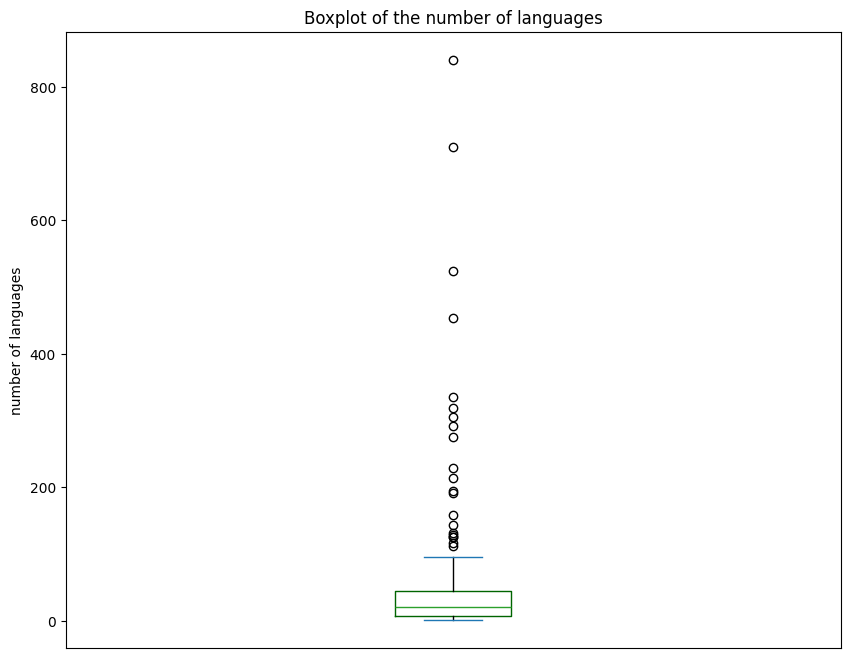

In [125]:
df.lang_count.plot(figsize = (10,8),
        kind = 'box',
        title = 'Boxplot of the number of languages',
        color = dict(boxes = 'darkgreen', whiskers = 'black'),
        grid=False
);
print(f'the median is {df.lang_count.median()}')
plt.ylabel('number of languages');
plt.xticks([]);


The boxplot reveals that the distribution of language count is heavily skewed to the right with many outliers, meaning that in most countries, very few languages are spoken. On average(*median*) 23 langauges are spoken in each country. But some countries representing outliers have more than 800 languages spoken. Lets have another look at the distribution by plotting it as a histogram. 

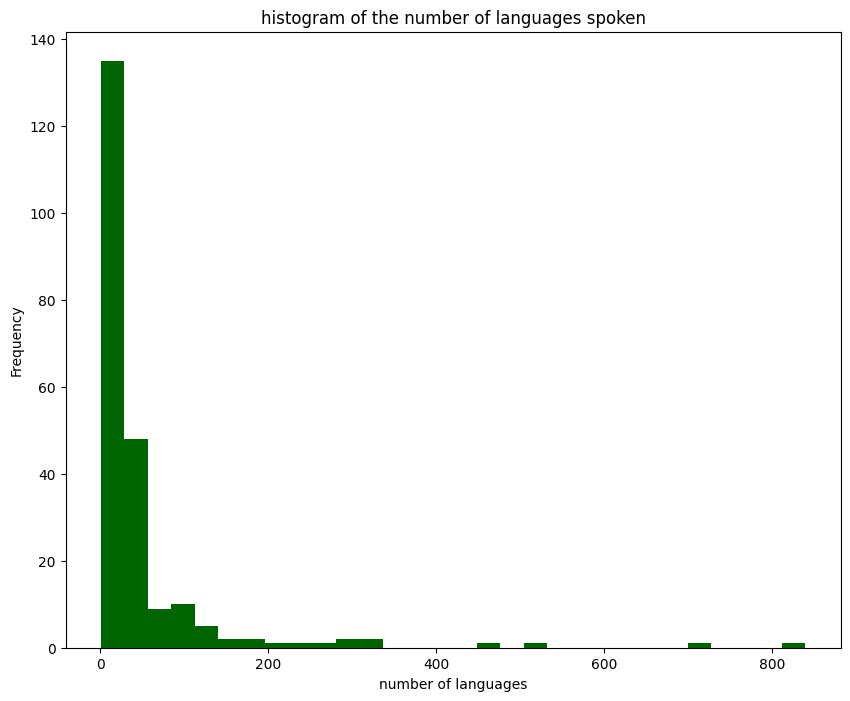

In [126]:
df.lang_count.plot(figsize=(10,8),
    kind = 'hist',
    color = 'darkgreen',
    title = 'histogram of the number of languages spoken',
    bins = 30,
    grid = False
)
plt.xlabel('number of languages');

Here we see clearly see the heavy right skew. Lets see how the disribution looks if we filter out outliers with more than 150 languages.

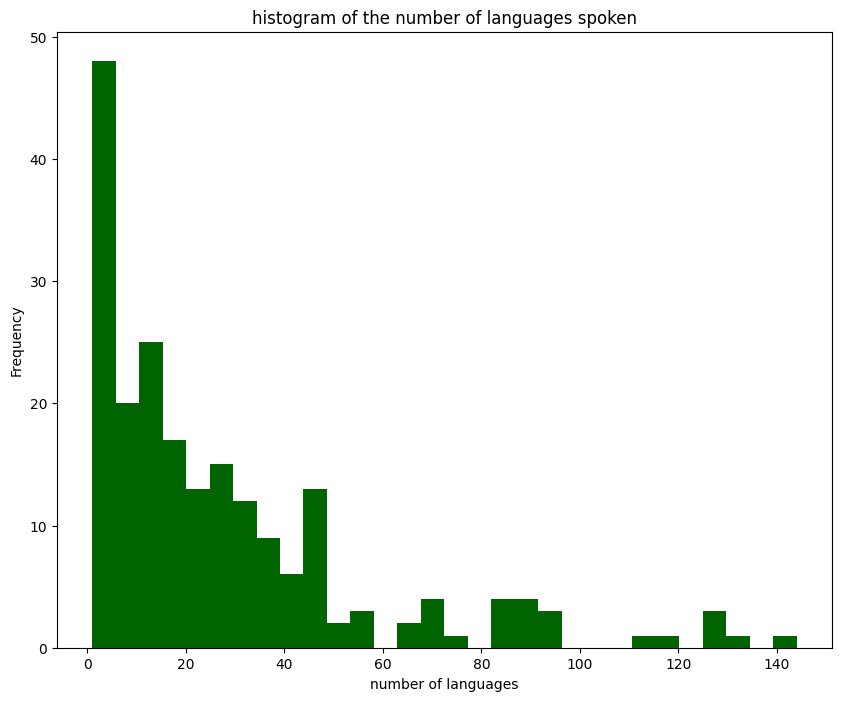

In [127]:
df.lang_count[df.lang_count < 150].plot(figsize=(10,8),
    kind = 'hist',
    color = 'darkgreen',
    title = 'histogram of the number of languages spoken',
    bins = 30
)
plt.xlabel('number of languages');

Now we see really clearly see the distribution with most countries having few languages, and from about 40 languages and upwards, the distribution is verys spread.

Now lets move on by takeing a look at which countries has the most respectively least number of languages.

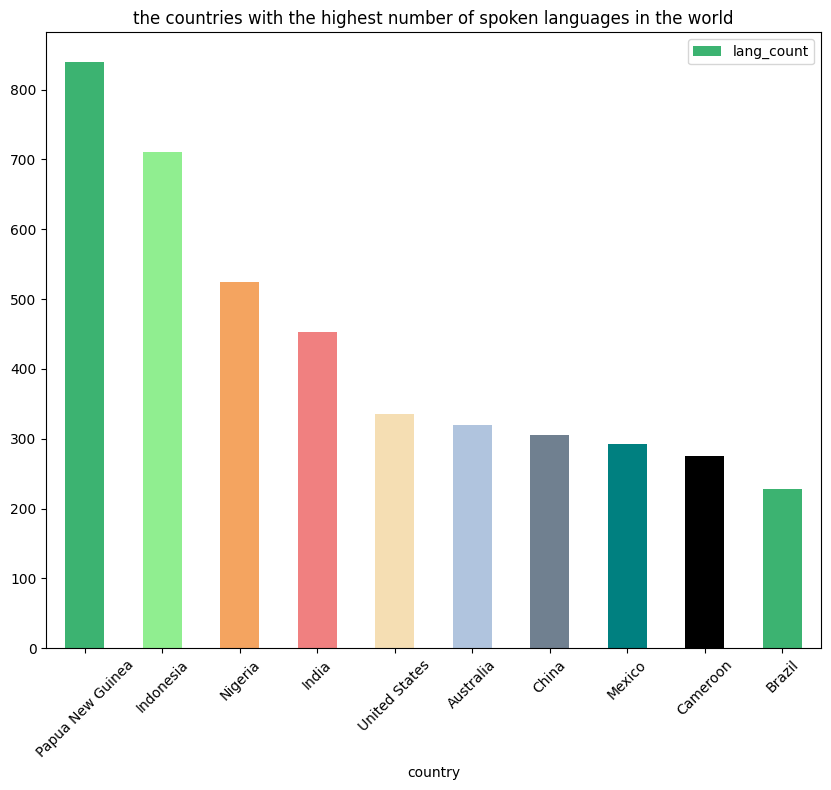

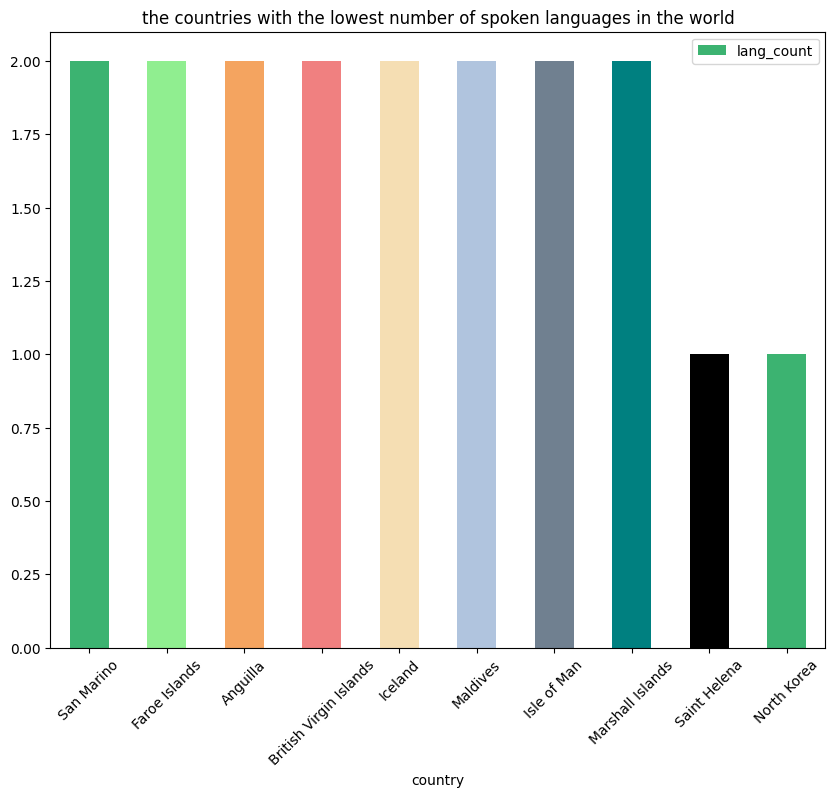

In [128]:
df.sort_values(by='lang_count', ascending=False).head(10).plot(figsize = (10,8),
    x = 'country',
    y = 'lang_count',
    kind = 'bar',
    rot = 45,
    color= ['mediumseagreen','lightgreen','sandybrown','lightcoral','wheat','lightsteelblue','slategrey','teal','black'],
    title= "the countries with the highest number of spoken languages in the world"
);

df.sort_values(by='lang_count', ascending=False).tail(10).plot(figsize = (10,8),
    x = 'country',
    y = 'lang_count',
    kind = 'bar',
    rot = 45,
    color= ['mediumseagreen','lightgreen','sandybrown','lightcoral','wheat','lightsteelblue','slategrey','teal','black'],
    title= "the countries with the lowest number of spoken languages in the world"
);


Now, just looking at the head and tail, quite some valueable insights are given. From the countries with the most languages, we find some notable names, like the USA, India, China and Brazil. Countries that are some of the most powerful and well known in the world. But looking at the countries with the lowest number of langauges spoken, just one to 3 languages, we find microstates with 9 out of 10 being islands.

To finish off this part about language count, lets look at another bar plot, but get an idea of geographical properties. There is a column in the data set called 'Region' but the regions are based on political regions, and not  geographical, so lets make it geographical by combining some regions into continents

In [129]:
df['continent'] = df['region']
cont_map = {'ASIA (EX. NEAR EAST)         ': 'Asia', 'NEAR EAST                          ': 'Asia', 'C.W. OF IND. STATES ':'Asia', 'NORTHERN AFRICA                    ': 'Africa','SUB-SAHARAN AFRICA                 ':'Africa', 'WESTERN EUROPE                     ':'Europe', 'EASTERN EUROPE                     ':'Europe', 'BALTICS                            ': 'Europe', 'LATIN AMER. & CARIB    ':'South America', 'NORTHERN AMERICA                   ': 'North America', 'OCEANIA                            ':'Oceania' }
df['continent'] = df['continent'].map(cont_map)


In [130]:
USSR = df.country.isin(['Russia', 'Belarus', 'Ukraine', 'Moldova'])
df[USSR].continent.replace('Asia', 'Europe');

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/1994741572.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


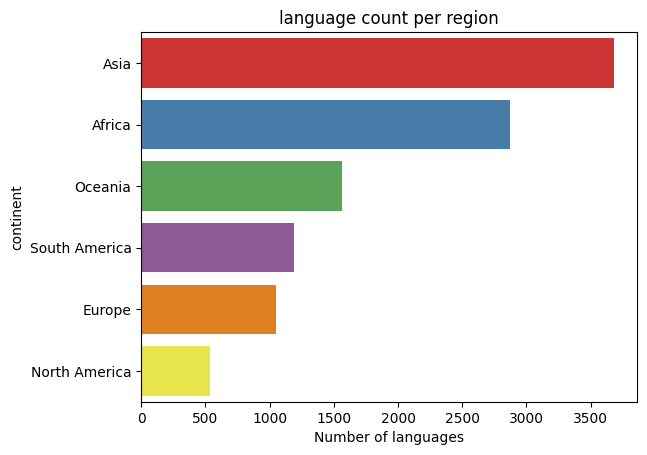

In [131]:
grouped = df.groupby('continent').lang_count.sum().sort_values(ascending=False)
sns.barplot(
    data=grouped,
    orient = 'h',
    palette='Set1'
);
plt.title('language count per region');
plt.xlabel('Number of languages');

As seen in the plot above, the continents with the most languages are Asia, Africa and Oceana, while the regions with the fewest languages are the Americas and Europe

Now, lets move on to looking at linguistic diversity, which just to refresh your memory is defined the likelhood that two random inhabitants of a country have the same mother tongue. 

### Linguistic Diveristy

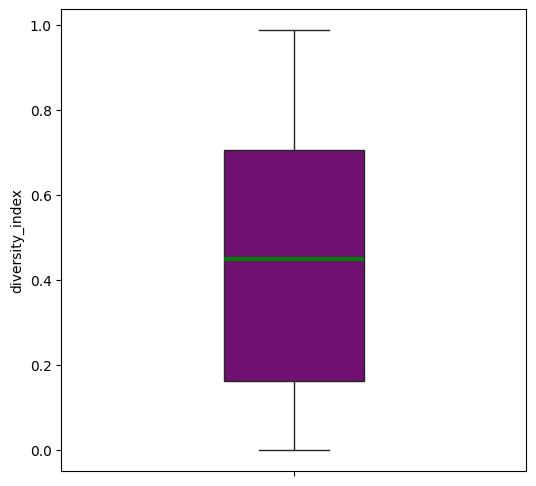

In [132]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(
    data = df,
    y = 'diversity_index',
    width = 0.3,
    color = 'purple',
    medianprops = dict(color ='green', linewidth=3)
)


The Boxplot for the linguistic diversity index is very neat, showing a median at a little below 0.5 and very evenly sized quartiles. One can notice a very very slight right tail skew however. Lets go ahead and also look at its histogram.

Text(0.5, 1.0, 'Histogram of the linguistic diversity index')

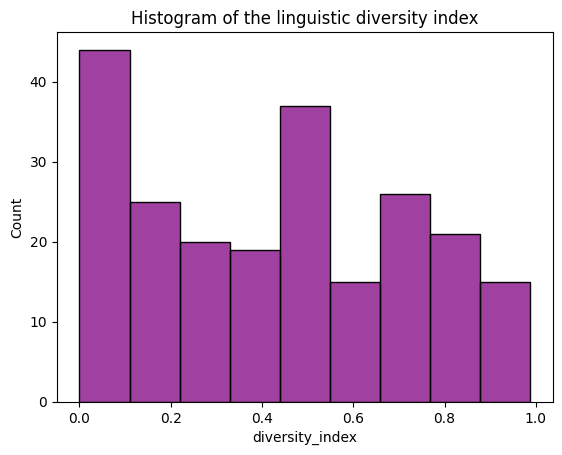

In [133]:

ax = sns.histplot(
    data = df,
    x = 'diversity_index',
    color = 'purple',
)
ax.set_title('Histogram of the linguistic diversity index')

We see here, that just as with the number of languages, there are many languages that have very little diversity, but still the distribution is far more even. It is logical to assume that in countries with many languages, the linguistic diversity is high, but this most not necessarily be the fact, as many of the languages could have very few speakers, with just one language being spoken by a clear majority. The discrepancy in the distribution hint towards this being true for the data, but lets plot the two variables against eachother for a better look.


Text(0.5, 0.5, 'r = 0.316 p = 0.0000')

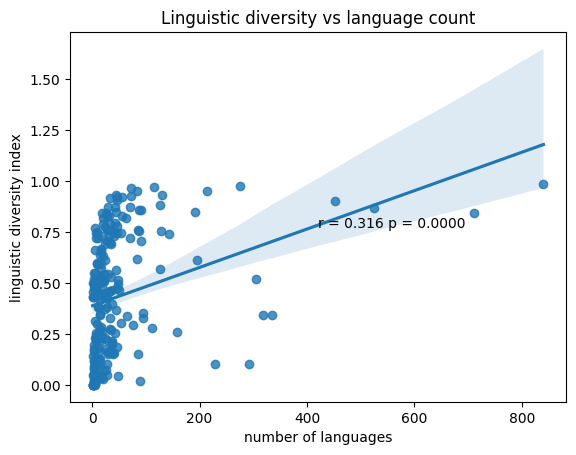

In [134]:
import scipy.stats as stats
fig, ax = plt.subplots(1,1)
sns.regplot(ax = ax, x ='lang_count', y = 'diversity_index', data = df)
ax.set_title( 'Linguistic diversity vs language count')
ax.set_xlabel('number of languages')
ax.set_ylabel('linguistic diversity index')
r, p = stats.pearsonr(df['lang_count'], df['diversity_index'])
ax.text(0.5,0.5,f'r = {r:.3f} p = {p:.4f}', transform=ax.transAxes, ha='left', va='top')



Looking at the plot, and considering the calculated r-value, there is indeed a correlation, albeit weak, r = 0.32
Now this plot has included the outliers, so lets do the same thing, but without the outliers that may be skewing the analysis.

Text(0.5, 0.5, 'r = 0.316010 p = 0.0000')

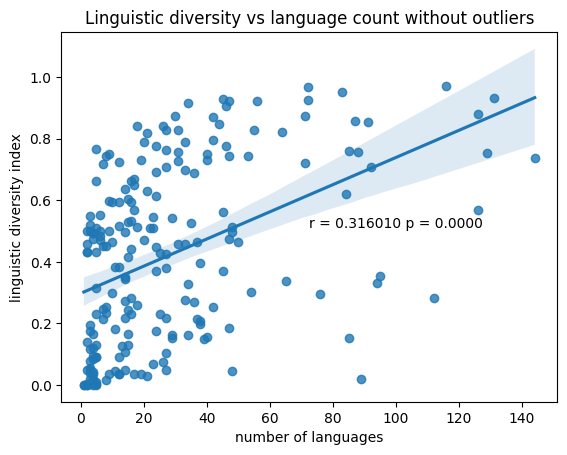

In [135]:
filter = df['lang_count'] < 150
filtered_LC = df['lang_count'][filter]
filtered_DI = df['diversity_index'][filter]
fig, ax = plt.subplots()
sns.regplot(ax = ax,x =filtered_LC, y = filtered_DI)
ax.set_title('Linguistic diversity vs language count without outliers')
ax.set_xlabel('number of languages')
ax.set_ylabel('linguistic diversity index')
r, p = stats.pearsonr(df['lang_count'], df['diversity_index'])
ax.text(0.5,0.5,f'r = {r:3f} p = {p:.4f}', transform=ax.transAxes, ha='left', va='top')


Looking at the graph without the outliers, the correlation is more clearly visible, but the strenth is still weak to moderate with r = 0.32. To conclude: A realtionship does indeed exists between the number of languages spoken in a country and its lingusitic diversity, but it doesn't tell the entire tale. 

Okay, now lets try to get an idea of what the geographical distribution looks. We will start by plotting box plots by continent to get an overview.

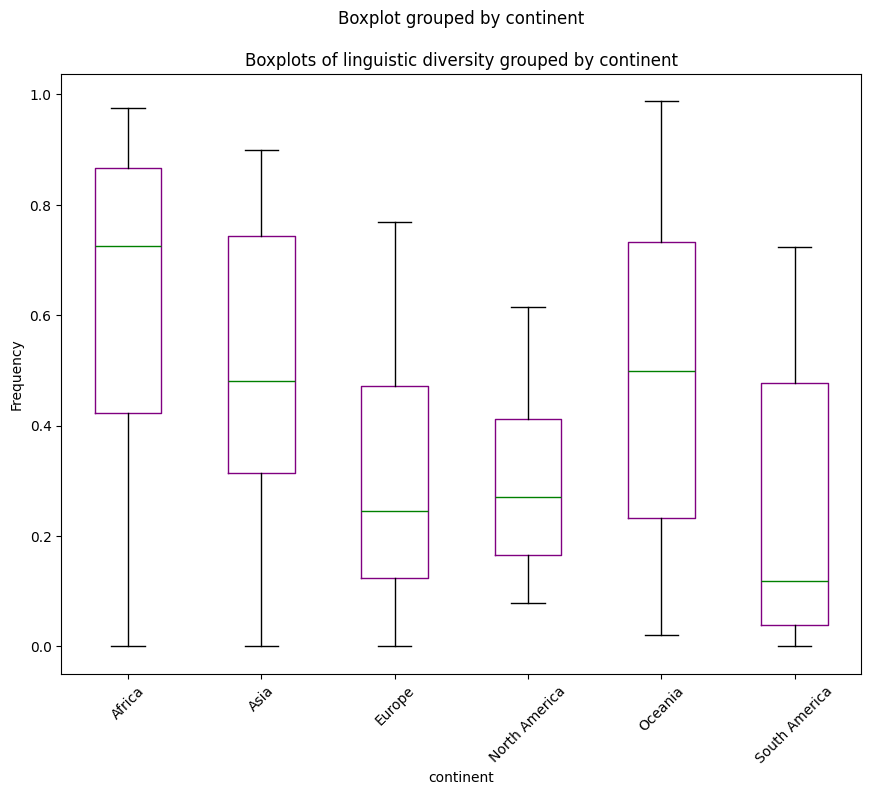

In [136]:

df.boxplot(figsize=(10,8),
    column='diversity_index',
     by= 'continent',
     grid=  False,
     rot = 45,
     color = dict(boxes = 'purple', whiskers = 'black', medians = 'green'),
);
plt.title('Boxplots of linguistic diversity grouped by continent');
plt.ylabel('Frequency');


Looking at the boxplots, we we see the same pattern as with the number of languages, Africa, Oceania and Asia are very diverse, while the americas and europe are less diverse. But we see that altough south america had a higher number of languages than Europe and North America, it actually rankst the lowest on linguistic diversity. The conclusion must be, that altough are a large number of lanagues in south america, they are all spoken by a small number of individuals, with the major languages spanish and portoguese being spoken by a very strong majority. 

As we with the diversity index have a nice scale from 0 to 1 for how diverse a country is, we can enhance our data by dividing them into different categories, from 'very low diversity', to 'very high diversity'. This way, we will be able to more easily make comparisons based on degree of linguistic diversity

In [137]:
diversity_categories = ['very low diversity', 'low diversity', 'moderate diversity', 'high diversity', 'very high diversity']
df['diversity_degree'] = pd.qcut(df.diversity_index, 5, diversity_categories)

To give an even better Idea of the the geographical distribution of linguistic diversity, and to sum up this inital exploratory data analysis concerning linguistic diversity, we will create a world map with our countries, coloring in the countries based on the previously created categories.

To do that, we need the geographical coordinates, which we will import from this dataset (https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state) and merge with ours existing one

In [138]:
cords = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
cords = cords[['country', 'latitude', 'longitude']]

In [139]:
cords.replace('Congo [DRC]', 'Democratic Republic of the Congo', inplace=True)
cords.replace('Congo [Republic]', 'Congo', inplace=True)
cords.replace('Cape Verde', 'Cape Verde Islands', inplace=True)
cords.replace('Gaza Strip', 'Palestine', inplace=True)
cords.replace('Macedonia [FYROM]', 'Macedonia', inplace=True)
cords.replace('Myanmar [Burma]', 'Myanmar', inplace=True)
cords.replace('São Tomé and Príncipe', 'São Tomé e Príncipe', inplace=True)
cords.replace('Swaziland', 'Eswatini', inplace=True)
cords.replace('Pitcairn Islands', 'Pitcairn', inplace=True)
cords.replace('Vietnam', 'Viet Nam', inplace=True)
cords.replace('Gaza Strip', 'Palestine', inplace=True)
cords.replace('Czech Republic', 'Czechia', inplace=True)

In [140]:
map = pd.merge(df, cords, on='country', how='inner')
map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 221 non-null    object  
 1   region                  221 non-null    object  
 2   population              221 non-null    int64   
 3   area                    221 non-null    int64   
 4   pop_density             221 non-null    float64 
 5   Coast/area              221 non-null    float64 
 6   net_migration           221 non-null    float64 
 7   infant_mortality        221 non-null    float64 
 8   GDP_per_capita          221 non-null    float64 
 9   literacy                221 non-null    float64 
 10  phones                  221 non-null    float64 
 11  birthrate               221 non-null    float64 
 12  deathrate               221 non-null    float64 
 13  agriculture             221 non-null    float64 
 14  industry                22

No missing values? Great, lets now go ahead an make a map :)

In [141]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"));

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/2345079206.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"));


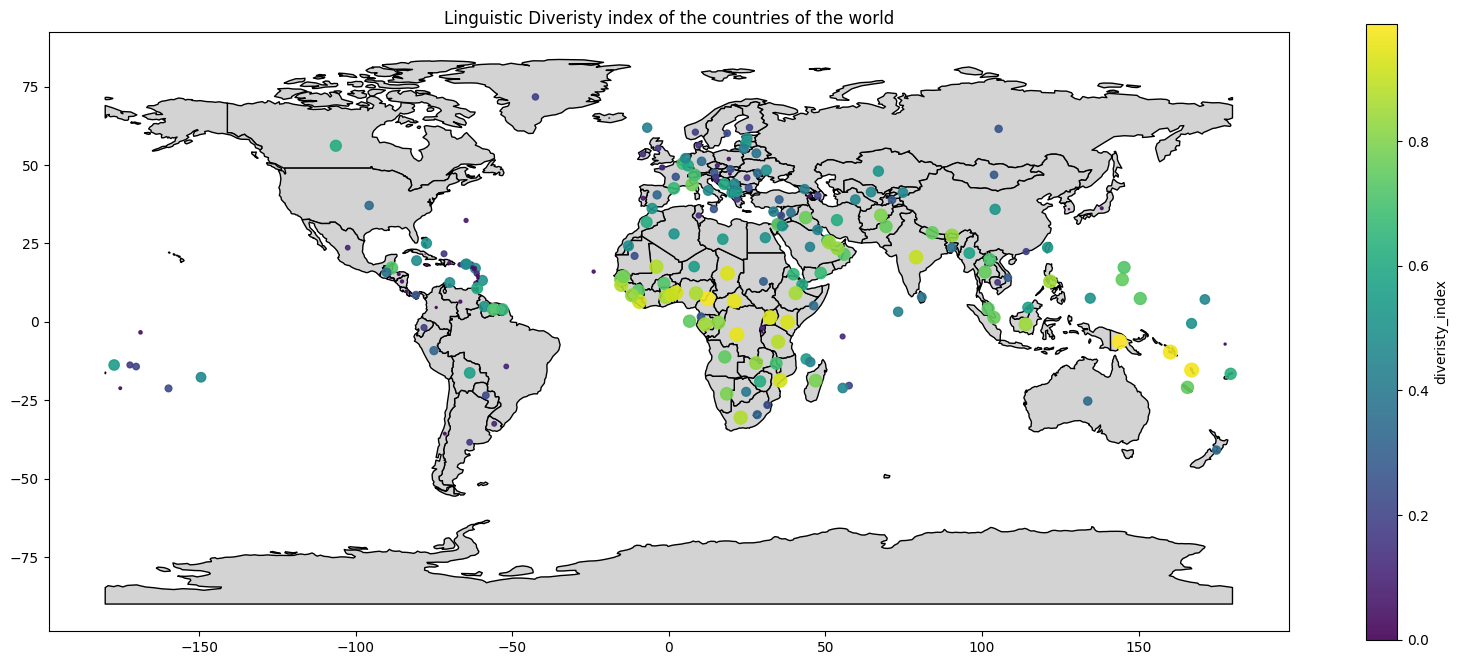

In [142]:
fig, ax = plt.subplots(figsize = (20,8))
world.plot(color = 'lightgrey', ax = ax, edgecolor = 'Black')
plt.scatter(
    map['longitude'],
    map['latitude'],
    s=100*map['diversity_index'],
    c=map['diversity_index'],
    cmap='viridis',
    alpha=0.9
    )
plt.colorbar(label='diveristy_index');
plt.title('Linguistic Diveristy index of the countries of the world');
ax.grid(False)


Now we have a simple map with the diversity index colored as dots on the maps, with purple and bluish signaling low diversity, and green and yellowish signaling high diversity. At a glanse, we identify two very diverse areas: Africa and southern Asia, and a not very divers area in Europe and America. And looking at the map, one could even detect a trend in that the closer to the equator one goes, the more linguistically divers it gets. Lets take a deeper look and test this hypothesis.

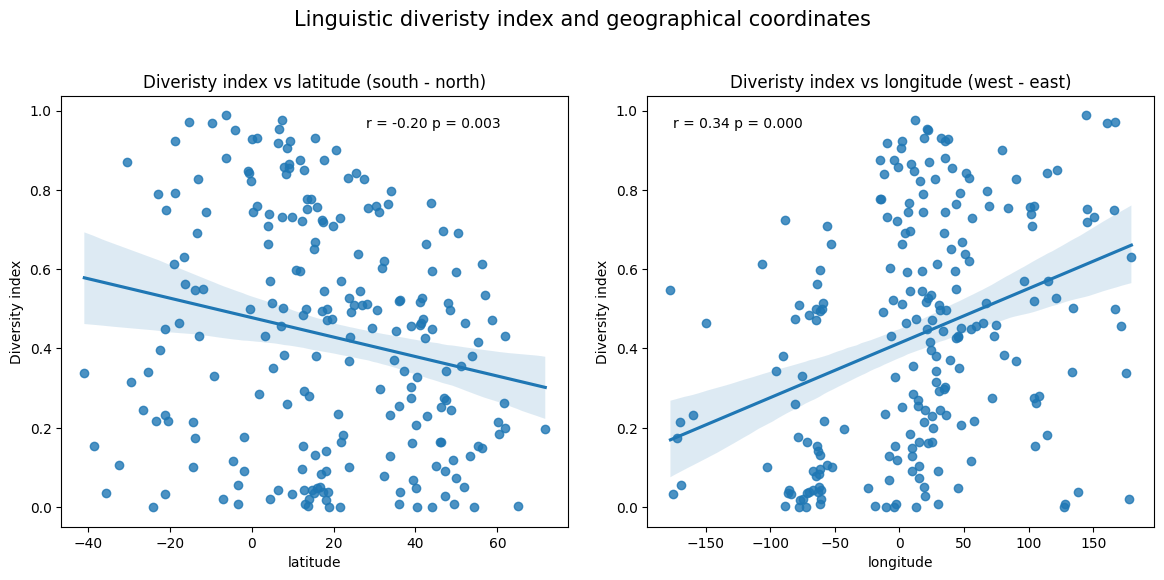

In [143]:

fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.regplot(ax = ax[0],
    x = 'latitude', y = 'diversity_index', data = map,
)
ax[0].set_title('Diveristy index vs latitude (south - north)')
ax[0].set_ylabel('Diversity index')
r1, p1 = stats.pearsonr(map['latitude'], map['diversity_index'])
ax[0].text(0.60, 0.95,f'r = {r1:.2f} p = {p1:.3f}', transform=ax[0].transAxes, ha='left', va='top');


sns.regplot( ax = ax[1],
    x = 'longitude', y = 'diversity_index', data = map,
)
ax[1].set_title('Diveristy index vs longitude (west - east)')
ax[1].set_ylabel('Diversity index')
r2, p2 = stats.pearsonr(map['longitude'], map['diversity_index'])
ax[1].text(0.05, 0.95,f'r = {r2:.2f} p = {p2:.3f}', transform=ax[1].transAxes, ha='left', va='top');
fig.suptitle('Linguistic diveristy index and geographical coordinates', fontsize = 15);

plt.tight_layout(pad = 2)

Looking at the graphs and the calculated correlation estamates, it seems that there is a correlation with north-south position, but also for east, west! This is quite problematic, since there shouldn't be a correlation between east and west, as they are always relative to each other. There must be an explanation for this to be found in the data and if we go back to look at the map, that in the western hemisphere (north and south america) there is very low lingusitic diversity, which has its roots in the colonial history, where spanish and portoguese took over, forcing away the langauages of the native americans. To really get a better understanding of the influence of geography, we should remove the american continent from the analysis. 

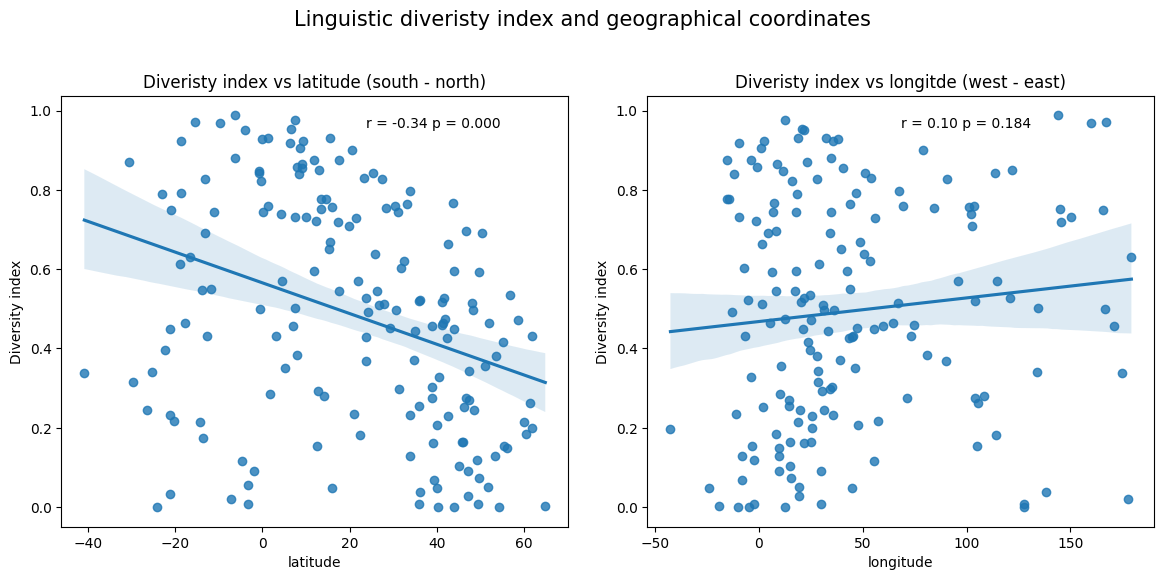

In [144]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

filter = map['continent'].isin(['Europe', 'Africa', 'Asia', 'Oceania'])

sns.regplot(ax = ax[0],
    x = 'latitude', y = 'diversity_index', data = map[filter],
)
ax[0].set_title('Diveristy index vs latitude (south - north)')
ax[0].set_ylabel('Diversity index')
r1, p1 = stats.pearsonr(map[filter]['latitude'], map[filter]['diversity_index'])
ax[0].text(0.60, 0.95,f'r = {r1:.2f} p = {p1:.3f}', transform=ax[0].transAxes, ha='left', va='top');


sns.regplot( ax = ax[1],
    x = 'longitude', y = 'diversity_index', data = map[map['longitude'] > -50],
)
ax[1].set_title('Diveristy index vs longitde (west - east)')
ax[1].set_ylabel('Diversity index')
r2, p2 = stats.pearsonr(map[map['longitude'] > -50]['longitude'], map[map['longitude'] > -50]['diversity_index'])
ax[1].text(0.50, 0.95,f'r = {r2:.2f} p = {p2:.3f}', transform=ax[1].transAxes, ha='left', va='top');
fig.suptitle('Linguistic diveristy index and geographical coordinates', fontsize = 15);

plt.tight_layout(pad = 2)

With South america removed from the equation, we see that in Eurasia and Africa, there is a significant week to moderate correlation between linguistic index and nort/south position, where the further north you go, the less linguisticly diverse the contries become. This suggest that there is a relationship between geography and linguistic diversity, with the most divers countries being located on the southern hemisphere. Now the quesiton is, is there any causuality? Could the difference in climate and hours of suntime have an impact on linguistic diversity, or is there other factors causing thi?. To be able to say, we need to dive into the part of the dataset concerning itself with economical and development factors, which the next part of the notebook will cover.

### Development factors

The most common and probably most robust predictor of human development is economical development. Countries with higher economic output can spend more on improving the lifes of it citizens, and citizens are benefitted by taken part in the value that is generated by a thriwing economy. The classic measure of economical development is GDP per capita, so lets beginn by diving deeper into this variable for our dataset.

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/3122945188.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/3122945188.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


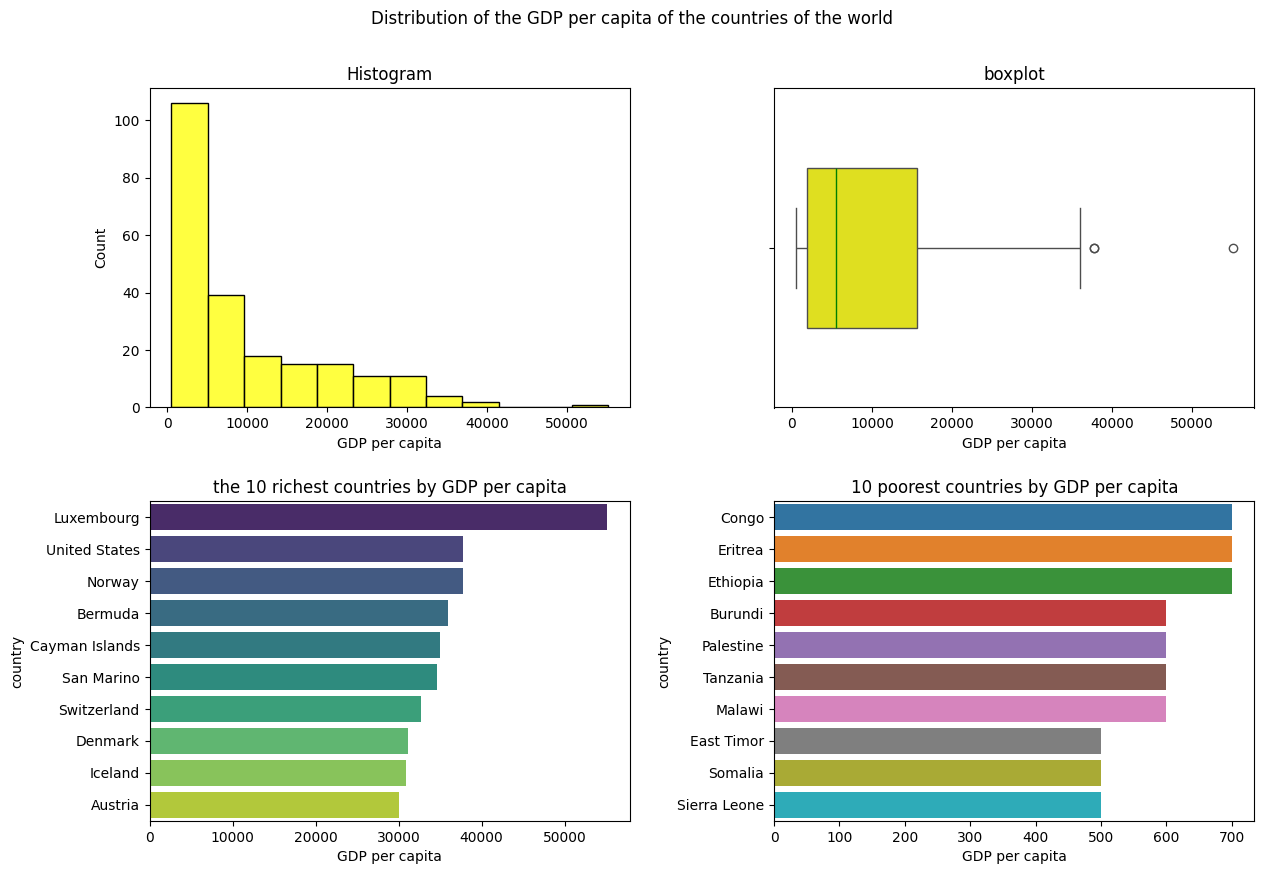

In [145]:
fig, ax = plt.subplots(2,2, figsize = (13,9))
sns.histplot(
    ax = ax[0,0],
    data = df,
    x = 'GDP_per_capita',
    color = 'yellow',
)
ax[0,0].set_title('Histogram')
ax[0,0].set_xlabel('GDP per capita')
sns.boxplot(
    ax = ax[0,1],
    data = df,
    x = 'GDP_per_capita',
    color = 'yellow',
    width = 0.5,
    medianprops = dict(color = 'green')
)
ax[0,1].set_title('boxplot')
ax[0,1].set_xlabel('GDP per capita')
top = df.sort_values(by= 'GDP_per_capita', ascending=False).head(10)
bot =  df.sort_values(by= 'GDP_per_capita', ascending=False).tail(10)
sns.barplot(
    ax = ax[1,0],
    data = top,
    x = 'GDP_per_capita',
    y = 'country',
    palette= 'viridis'
    
)
ax[1,0].set_xlabel('GDP per capita')
ax[1,0].set_title('the 10 richest countries by GDP per capita')
sns.barplot(
    ax = ax[1,1],
    data = bot,
    x = 'GDP_per_capita',
    y = 'country',
    palette = 'tab10'
)
ax[1,1].set_xlabel('GDP per capita');
ax[1,1].set_title('10 poorest countries by GDP per capita');
plt.suptitle('Distribution of the GDP per capita of the countries of the world');

plt.tight_layout(pad = 2)

Looking at theses descriptive graphs, we get an idea of the distribution, most of the countries of the world is in fact on the poor end of the spectrum with a median GDP per capita of about 6000. To conclude, the wealth of the world is very unevenly being distributed, with a few very rich countries compared to the others. Which are these countries? Well we get an idea by looking bar plots of the 10 poorest and 10 richest countries of the world, with many of the rich countries being european, and the poorest countries being African and South Asian. To really get a full idea however, we should plot the GDP per capita and group it by continent.

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/3538251124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( ax = ax,


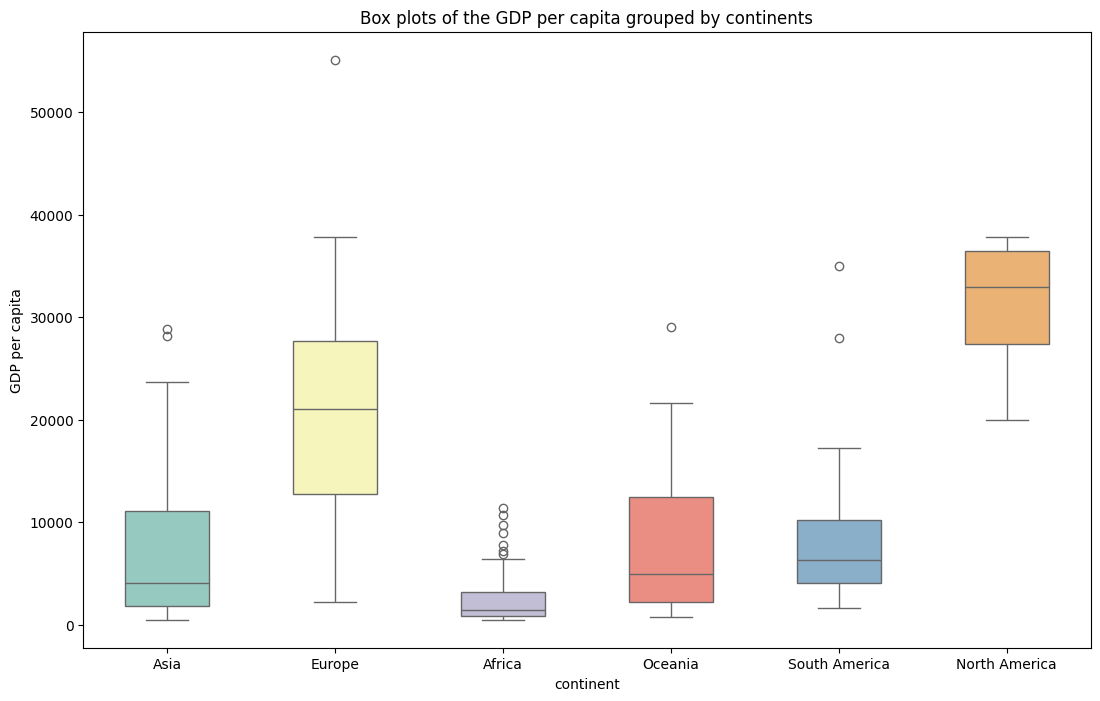

In [146]:
fig, ax = plt.subplots(figsize=(13,8))
sns.boxplot( ax = ax,
    data = df,
    x = 'continent',
    y = 'GDP_per_capita',
    palette = 'Set3',
    width = 0.5
)
ax.set_title('Box plots of the GDP per capita grouped by continents');
ax.set_ylabel('GDP per capita');

Looking at the distribution per continent, we notice that there are very large differences. The by far richest continents are North America and Europe, with Europe being more diverse having very poor and rich countries. The by far poor continent is Africa. To be able to make a further comparison, we will look at a barplot of the means.

/var/folders/pt/26yk257s5nd579ngn9gyw3k40000gn/T/ipykernel_12473/3919411086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


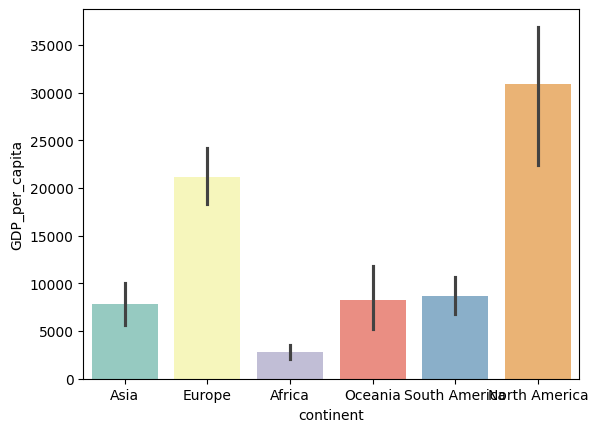

In [147]:
means = df.groupby('continent').GDP_per_capita.mean()
#fig, ax = plt.subplt(figsize = (13,9))
sns.barplot(
   data = df,
   x = 'continent',
   y = 'GDP_per_capita',
   palette = 'Set3'
);


The Barplot supports our previous conclusion, that the richest regions are Europe and Northamerica, whose Average GDP are not significantly different from each other, then quite a way down we find Asia, Oceania and South America, that aren't significantly different from eachother, but clearly poorer than Europe and North America, and the poorest region measured på GDP per capita ist without doubt Africa. 

Considering this, it would make sense to create categorizes to categorize countries from poor to rich. 

In [148]:
economic_categories = ['very poor', 'poor', 'moderately poor', 'rich', 'very rich']
df['economic_categories'] = pd.qcut(df.GDP_per_capita, 5, economic_categories)

Now we have had a explored the most important variables in our dataset, and we have investigated the relationship between lingusitic diveristy and number of languages as well as with geography. We thus finish this first part of the notebook. The next steps will be too investigate the development factors, and see how they relate to each other, and to what extent they can predict linguistic diversity.